In [1]:
import sys
sys.path.append('../vectorsearch/')
import vectorsearch
import pandas as pd
import pickle

/home/carlson/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


path /data/insight_yelp/input/


In [2]:
df_businesses = pd.read_pickle('../input/yelp_academic_dataset_business_SF.pickle')
reviews = pd.read_pickle('../output/bar_reviews_cleaned_and_tokenized_SF.pickle')

def get_bus_ids_city_state(city, state):
    return set(list(df_businesses.business_id[(df_businesses.city.str.lower()==city.lower()) 
                                     & (df_businesses.state.str.lower()==state.lower())].values))


training_users = pickle.load(open('../output/training_users.pickle', 'rb'))
test_users     = pickle.load(open('../output/test_users.pickle', 'rb'))

# Make the active review set training only 
review_train = reviews[reviews.user_id.isin(training_users)]
review_test = reviews[reviews.user_id.isin(test_users)]






In [6]:
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [64]:


def GetDocumentRank(review_text, real_bus_id, bus_ids_in_city_state):
    '''
    Given a document review, search businesses in that city, state and return the rank from the top of the list. 
    
    
    '''
    top_n = 1000 # Number of topics to choose for top of list. 
    rev_topic = np.array(vectorsearch.GetDocTopic(review_text, n_jobs=1),)
    
    
    #real_business = df_businesses[df_businesses.business_id==real_bus_id]
    #city, state = real_business.city.values[0], real_business.state.values[0]
    
    # Lookup only businesses in the city/state
    #bus_ids_in_city_state = get_bus_ids_city_state(city.strip().lower(), state.strip().lower())
    # Get the topic vector for the review 
    # topic_listings = [" ".join(vectorsearch.GetTopicWords(topic, ))  for topic in top_n_topics]
    # Find similarity with the businesses of interst (in the city state)
    top_bus_id, top_bus_sim = vectorsearch.FindBusinessSimilarityLDA(rev_topic, 
                                                                     business_ids=bus_ids_in_city_state,
                                                                     top_n=top_n)
    
    # Length of cleaned and tokenized document for segmentation.
    doc_length = vectorsearch.GetDocLength(review_text)
    # where in the results was the true business?
    try:
        rank = np.argwhere(top_bus_id==real_bus_id)[0][0]+1
    except:
        rank = float('NaN')
    return rank, doc_length



def get_bus_ids_city_state(city, state):
    bids =  set(list(df_businesses.business_id[(df_businesses.city==city) 
                                     & (df_businesses.state==state)].values))
    return bids


from multiprocessing import pool 

def RunValidation(review_set, city, state):
    ranks, doc_lengths = [], [] 
    bids = get_bus_ids_city_state(city, state)
    validation_set = review_set[review_set.business_id.isin(bids)]
    
#     f = lambda x: GetDocumentRank(x[0],x[1])
#     p = pool.Pool(6)
    
    for i_rev in range(len(validation_set)):
        row = validation_set.iloc[i_rev]
        try:
            if (i_rev%50==0): 
                print '\r progress %i of'%i_rev, len(validation_set), 
            rank, doc_length = GetDocumentRank(row.text, row.business_id, bids)
            ranks.append(rank)
            doc_lengths.append(doc_length)
        except:
            pass
        
#     p.close()
#     p.join()
    return bids, ranks, doc_lengths
#         except:
#             print "Not in top_n"

#%load_ext line_profiler
#%prun RunValidation(review_test, "San Francisco", "CA")
test_results = RunValidation(review_test, "San Francisco", "CA")
print "TEST SET DONE"
train_results = RunValidation(review_train[:], "San Francisco", "CA")
print "TRAIN SET DONE"


 progress 16500 of 16544 TEST SET DONE
 progress 66550 of 66562 TRAIN SET DONE


Num NaN's 6
[ 25  52  46 ..., 157  40 132]


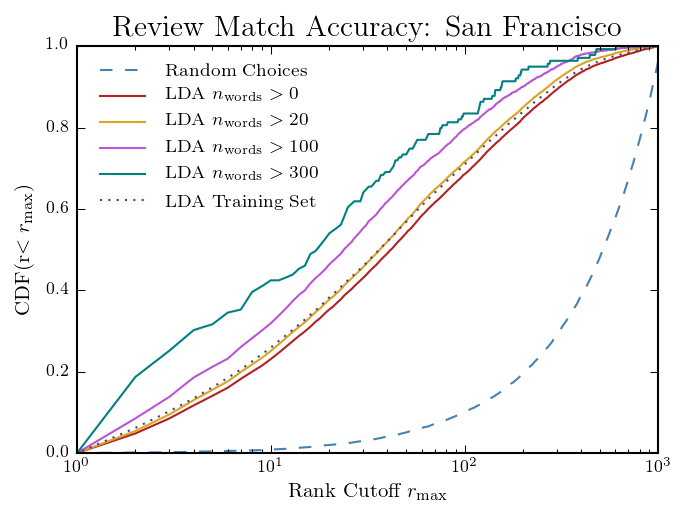

In [66]:
ranks = np.array(test_results[1])
n_businesses = len(test_results[0])
doc_lengths = np.array(test_results[2])

ranks_train = np.array(train_results[1])
n_businesses = len(train_results[0])
doc_lengths_train = np.array(train_results[2])


# Random Choices....
random_choices = np.random.randint(1, n_businesses, len(ranks))
CDF = np.array([np.sum(random_choices<i) for i in range(n_businesses)])/float(len(random_choices))
plt.plot(range(n_businesses), CDF, label='Random Choices', linestyle='--')


def GetCDFDocLength(min_length):
    ranks_tmp = ranks[doc_lengths>min_length]
    CDF = np.array([np.sum(ranks_tmp<i) for i in range(n_businesses)])/float(len(ranks_tmp))
    return CDF

print "Num NaN's", np.sum(np.isnan(ranks))
doc_lengths = doc_lengths[~np.isnan(ranks)]
ranks = ranks[~np.isnan(ranks)]
print doc_lengths

for min_length in [0,20,100,300]:
    CDF = GetCDFDocLength(min_length)
    plt.plot(range(n_businesses),CDF, label=r'LDA $n_{\rm words}>%i$'%min_length)


CDF = np.array([np.sum(ranks_train<i) for i in range(n_businesses)])/float(len(ranks_train))
plt.plot(range(n_businesses), CDF, label=r'LDA Training Set', linestyle=':')

plt.legend(loc=2, frameon=False, handlelength=3)
plt.xscale('log')
plt.xlim(1,1e3)
plt.xlabel(r'Rank Cutoff $r_{\rm max}$')
plt.ylabel(r'CDF(r$<r_{\rm max}$)')
plt.title('Review Match Accuracy: San Francisco')

In [26]:
import yelp

yelp_api = yelp.Api(consumer_key='SddBgAA4qAbxz-UhAS0D7A',
                    consumer_secret='z-d2Q7yB963kMcusvLVm9I2Jylg',
                    access_token_key='KL574SXMJijEoO1_poHKhm6gHnSbwNlS',
                    access_token_secret='bn7i1wGZ8hNK5MLuykvMwfpEB4g')


def SearchYelpReviews(review, location, real_bus_URL):
    search_results = yelp_api.Search(term=review, location=location, 
#                                  cll=str(lat)+','+str(lon), radius_filter=radius, 
                                 limit=100, category_filter='bars') # location and search term are required
    
    for i, bus in enumerate(search_results.businesses):
        if bus.url == real_bus_URL:
            return i+1
        else:
            return 999
    
    return rank







search_results.businesses[0].url = search_results.businesses[0].url.split('?')[0]

NameError: name 'name' is not defined

In [28]:
df_businesses.latitude, df_businesses.longitude

(0       33.499313
 1       40.350519
 2       40.356896
 3       40.357620
 4       40.408735
 5       40.415517
 6       40.394588
 7       40.405404
 8       40.406324
 9       40.387732
 10      40.387732
 11      40.396469
 12      40.396744
 13      40.404638
 14      40.417419
 15      40.408670
 16      40.408568
 17      40.407889
 18      40.386891
 19      40.390760
 20      40.408343
 21      40.391255
 22      40.394305
 23      40.408257
 24      40.470457
 25      40.412086
 26      40.411692
 27      40.407091
 28      40.414064
 29      40.413496
           ...    
 1065          NaN
 1066          NaN
 1067          NaN
 1068          NaN
 1069          NaN
 1070          NaN
 1071          NaN
 1072          NaN
 1073          NaN
 1074          NaN
 1075          NaN
 1076          NaN
 1077          NaN
 1078          NaN
 1079          NaN
 1080          NaN
 1081          NaN
 1082          NaN
 1083          NaN
 1084          NaN
 1085          NaN
 1086       

In [33]:
set(df_businesses[df_businesses.business_id.isin(set(review_test.business_id.values))].city)

{u'Ahwatukee',
 u'Anthem',
 u'Apache Junction',
 u'Avondale',
 u'Beaconsfield',
 u'Belmont',
 u'Bloomfield',
 u'Boisbriand',
 u'Boulder City',
 u'Braddock',
 u'Bridgeville',
 u'Brossard',
 u'Buckeye',
 u'Cambridge',
 u'Carefree',
 u'Carnegie',
 u'Casa Grande',
 u'Cave Creek',
 u'Champaign',
 u'Chandler',
 u'Charlotte',
 u'Chateau',
 u'Concord',
 u'Concord Mills',
 u'Coolidge',
 u'DeForest',
 u'Dollard-Des-Ormeaux',
 u'Dormont',
 u'Dorval',
 u'Edinburgh',
 u'Eggenstein-Leopoldshafen',
 u'Ettlingen',
 u'Fitchburg',
 u'Florence',
 u'Fort McDowell',
 u'Fort Mill',
 u'Fort mill',
 u'Fountain Hills',
 u'Gilbert',
 u'Glendale',
 u'Goodyear',
 u'Greenfield Park',
 u'Henderson',
 u'Higley',
 u'Homestead',
 u'Karlsruhe',
 u'Kitchener',
 u"L'\xcele-des-Soeurs",
 u'Lake Wylie',
 u'Las Vegas',
 u'Las Vegas ',
 u'Lasswade',
 u'Laval',
 u'Laveen',
 u'Lawrenceville',
 u'Litchfield Park',
 u'Madison',
 u'Maricopa',
 u'Matthews',
 u'Mc Farland',
 u'McKees Rocks',
 u'Mcfarland',
 u'Mesa',
 u'Middleton',


In [15]:
print len(set(list(df_businesses.business_id[(df_businesses.city.str.lower()=='San Francisco'.lower()) 
                                     & (df_businesses.state.str.lower()=='ca')].values)))

1035


In [23]:
def get_bus_ids_city_state(city, state):
    return set(list(df_businesses.business_id[(df_businesses.city.str.lower()==city.lower()) 
                                     & (df_businesses.state.str.lower()==state.lower())].values))

len(get_bus_ids_city_state('San Francisco', 'CA'))

1035